# Notebook expérimental
## Mars Express Data Driven Digital Twin
---


Problème principal : "Kernel died" **au moment du sort by date** à cause de la RAM si on prend **l'année martienne entière** (~ 2008-2010) ce qui correspond au tri d'environ **3 millions de lignes**

Pour les mêmes raisons de limite de RAM on effectue nos prédictions que sur une seule des 33 variables *power*

*Note : On s'y prend peut être mal pour la partie interpolation. On veut d'abord interpoler/échantillonner tout le monde sur le niveau le plus fin pour ensuite appliquer notre filtre de sous-échantillonage que l'on veut (par h, par 30min ...)*

---
D'après nos tests sur la limite de RAM de nos pc on a pu voir que :
* Avec 4 mois de données seulement, on obtient des résultats aberrants avec une régression linéaire, comme on te l'a expliqué par mail 
* Avec 1 année terrestre (quasi limite pour la RAM) on a quelque chose de plus sympa, on retrouve effectivement les effets de périodicité que tu as cité dans le mail, invisibles sur 4 mois.
---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import models, layers, initializers

In [2]:
FOLDER = "../data_MEX/train_set/"

In [3]:

## import de la première année d'une classe de variables quantitative (saaf, ltdata)
def import_all(folder = FOLDER):
    
    """
    Import all files for one martian year and apply specific preprocessing regarding variable types in the file.
    Return a list of DataFrames
    """
    
    
    file_types = ["power", "saaf", "dmop", "ltdata", "ftl"]
    quantitative = ["ltdata", 'saaf']
    df_list = []
    col = 'NPWD2451' # colonne 1 sur 33 de power
    for file_type in file_types:
        print('Importing', file_type, "data ...")
        query = f"{folder}*{file_type}*"
        file_name_list = glob.glob(query) 
        file_name_first = np.sort(file_name_list)[0] # on récupère la première année martienne
        if file_type != 'power':
            
            data = pd.read_csv(file_name_first, sep=",", index_col=0) # index -> ut_ms

            if file_type == "dmop":
                data['commande'] = data.apply(lambda x : x['subsystem'][:4], axis=1)
                #data['len'] = data.apply(lambda x : len(x['subsystem'].split(".")), axis=1)
                data = pd.get_dummies(data[["commande"]]) #One Hot Encoding (naïf)
                
            elif file_type == "ftl":
                data = pd.get_dummies(data[["type", "flagcomms"]]) #One Hot Encoding (naïf)
                data["flagcomms"] = data["flagcomms"].astype(int) # Passer les true/false en 1/0
                
        else:
            print("--> importing only", col, "column out of 33 columns")
            data = pd.read_csv(file_name_first, sep=",", index_col=0, usecols = ["ut_ms", col])
            
        data['date'] = data.index
        data = data.reset_index(drop=True)   
        data = data.loc[data["date"] < 1249084800000] # < au 01/08/2009 pour la RAM
        df_list.append(data)
            
    return df_list
    

# Copie des df puis concatenation 
# on trie par date -> ça intercale les mesures ltdata au milieu de celles de saaf
# on interpole tout ce qui manque (NaN) linéairement avec la méthode interpolate de pandas
# et PAF

def interpolate(df_list):
    """
    Concatenate a list of DataFrames, sort by date and interpolate (linearly or pad interpolation.
    """
    
    print("Concatenate ...")
    combined = pd.concat(df_list)
    print(f"-> Concatenate done, {len(combined)} rows.\n Sort by date ...")
    combined = combined.sort_values("date").reset_index(drop=True)
    print("-> Sort done")
    col = list(combined.columns)
    print("Interpolating")
    for c in col:
        print("->", c)
        if c.split('_')[0] == "type" or c == "flagcomms" or c == "commande" : #categorical data
            combined[c] = combined[c].interpolate(method="pad")
        else : #quantitative data
            combined[c] = combined[c].interpolate(method="linear")
    combined["interval"] = pd.Series(combined["date"][1:].to_numpy() - combined["date"][:-1].to_numpy())
    print("Data interpolated")
#     combined.dropna(inplace=True)
    return combined


def create_sampling_rate_vec(sec_interval, df):
    """
    Create a date (ut_ms format) vector piecewiesely continuous during "sec_interval" seconds.
    (To be used for "groupby" purposes) 
    """
    timestep = sec_interval * 1000
    median_interval = df["interval"].median()
    nb_samples = len(df) 
    group_size = int(timestep // median_interval)
    nb_group = int(nb_samples // group_size)
    print(f"Sample groups : {nb_group}")
    vec = np.zeros(nb_samples)
    for i in range(nb_group):
        vec[group_size * i: group_size * (i + 1)] = [df["date"][i * group_size]] * group_size

    vec[group_size * nb_group :] = [df["date"][ nb_group * group_size]] * len(vec[group_size * nb_group : ])
    return vec

def subsample_df(df, sampling_rate_sec = 3600):
    """
    Subsample all columns of df with a sampling rate in seconds
    """
    group_vector = create_sampling_rate_vec(sampling_rate_sec, df)
    df["groups"] = group_vector
    df = df.groupby(by="groups").mean() ## place groups en index du df
    df = df.reset_index()
    df.drop(["interval", "groups"], inplace = True, axis = 1)
    print("Data subsampled")
    return df

In [4]:
df_list = import_all()

Importing power data ...
--> importing only NPWD2451 column out of 33 columns


/home/yamsok/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Importing saaf data ...


/home/yamsok/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Importing dmop data ...
Importing ltdata data ...
Importing ftl data ...


In [5]:
# Kernel died ici si trop de valeurs
minute_sampled_data_interpolated = interpolate(df_list) 

Concatenate ...
-> Concatenate done, 1689514 rows.
 Sort by date ...
-> Sort done
Interpolating
-> NPWD2451
-> date
-> sa
-> sx
-> sy
-> sz
-> commande_AAAA
-> commande_AHHH
-> commande_AMMM
-> commande_AOOO
-> commande_APSF
-> commande_APWF
-> commande_ASEQ
-> commande_ASSS
-> commande_ASXX
-> commande_ATMB
-> commande_ATTT
-> commande_AVVV
-> commande_AXXX
-> commande_MAPO
-> commande_MOCE
-> commande_MOCS
-> commande_MPER
-> commande_PDNE
-> commande_PDNS
-> commande_PENE
-> commande_PENS
-> commande_PPNE
-> commande_PPNS
-> commande_SCMN
-> commande_UPBE
-> commande_UPBS
-> sunmars_km
-> earthmars_km
-> sunmarsearthangle_deg
-> solarconstantmars
-> eclipseduration_min
-> occultationduration_min
-> flagcomms
-> type_ACROSS_TRACK
-> type_D1PVMC
-> type_D2PLND
-> type_D3POCM
-> type_D4PNPO
-> type_D5PPHB
-> type_EARTH
-> type_INERTIAL
-> type_MAINTENANCE
-> type_NADIR
-> type_RADIO_SCIENCE
-> type_SLEW
-> type_SPECULAR
-> type_WARMUP
Data interpolated


In [8]:
minute_sampled_data_interpolated # Contient des NaNs, supprimés dans subsample_df

,NPWD2451,date,sa,sx,sy,sz,commande_AAAA,commande_AHHH,commande_AMMM,commande_AOOO,...,type_EARTH,type_INERTIAL,type_MAINTENANCE,type_NADIR,type_RADIO_SCIENCE,type_SLEW,type_SPECULAR,type_WARMUP,interval,groups
0,NaN,1219363200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9542.0,1.219363e+12
1,0.005015,1219363209542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1458.0,1.219363e+12
2,0.005216,1219363211000,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,1.219363e+12
3,0.005417,1219363213000,0.32,14.550,90.32,104.55,0.011905,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.219363e+12
4,0.005617,1219363213000,0.33,14.555,90.33,104.55,0.023810,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22000.0,1.219363e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689509,0.005015,1249084712467,0.11,30.110,90.11,120.11,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10533.0,1.249085e+12
1689510,0.005015,1249084723000,0.11,30.110,90.11,120.11,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,21471.0,1.249085e+12
1689511,0.005015,1249084744471,0.11,30.110,90.11,120.11,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,31996.0,1.249085e+12
1689512,0.005015,1249084776467,0.11,30.110,90.11,120.11,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6533.0,1.249085e+12


In [18]:
minute_sampled_data_interpolated.info() # memory usage (en bas) = 700 Mo !!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689514 entries, 0 to 1689513
Data columns (total 55 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   NPWD2451                 1689513 non-null  float64
 1   date                     1689514 non-null  int64  
 2   sa                       1689511 non-null  float64
 3   sx                       1689511 non-null  float64
 4   sy                       1689511 non-null  float64
 5   sz                       1689511 non-null  float64
 6   commande_AAAA            1689512 non-null  float64
 7   commande_AHHH            1689512 non-null  float64
 8   commande_AMMM            1689512 non-null  float64
 9   commande_AOOO            1689512 non-null  float64
 10  commande_APSF            1689512 non-null  float64
 11  commande_APWF            1689512 non-null  float64
 12  commande_ASEQ            1689512 non-null  float64
 13  commande_ASSS            1689512 non-null 

In [7]:
data = subsample_df(minute_sampled_data_interpolated)
# Pour l'instant le subsample est identique pour chaques colonnes
# On fait une moyenne
# On prévoit d'ajuster avec un min/max pour les variables qualitatives par ex.

Sample groups : 7750
Data subsampled


In [9]:
data

,NPWD2451,date,sa,sx,sy,sz,commande_AAAA,commande_AHHH,commande_AMMM,commande_AOOO,...,type_D4PNPO,type_D5PPHB,type_EARTH,type_INERTIAL,type_MAINTENANCE,type_NADIR,type_RADIO_SCIENCE,type_SLEW,type_SPECULAR,type_WARMUP
0,0.853104,1.219365e+12,0.339628,14.550930,90.339628,104.547535,0.296296,0.0,0.000000,0.0,...,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,0.630394,1.219369e+12,6.161583,18.182752,90.357661,91.153028,0.000000,0.0,0.247706,0.0,...,0.0,0.0,0.605505,0.000000,0.0,0.105505,0.000000,0.288991,0.0,0.0
2,1.048312,1.219371e+12,32.647661,39.382844,61.147661,74.013005,0.000000,0.0,0.157274,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0
3,1.028987,1.219374e+12,16.443784,26.044472,79.150573,111.432248,0.068807,0.0,0.202818,0.0,...,0.0,0.0,0.247706,0.000000,0.0,0.256881,0.000000,0.495413,0.0,0.0
4,0.904385,1.219378e+12,0.339771,14.527706,90.339771,104.523211,0.000000,0.0,0.000000,0.0,...,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7746,0.378779,1.249053e+12,0.110000,30.080000,90.110000,120.080000,0.198975,0.0,0.000000,0.0,...,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
7747,1.092840,1.249062e+12,6.422752,25.438922,96.194083,107.104014,0.227064,0.0,0.098624,0.0,...,0.0,0.0,0.504587,0.087156,0.0,0.027523,0.000000,0.380734,0.0,0.0
7748,1.092840,1.249072e+12,4.982271,26.124794,91.344495,113.330413,0.385186,0.0,0.105505,0.0,...,0.0,0.0,0.633028,0.000000,0.0,0.293578,0.000000,0.073394,0.0,0.0
7749,0.654178,1.249082e+12,0.110000,30.110000,90.110000,120.110000,0.238667,0.0,0.000000,0.0,...,0.0,0.0,0.862385,0.000000,0.0,0.000000,0.137615,0.000000,0.0,0.0


In [10]:
X = data.copy()
X.drop(["NPWD2451", "date"], inplace = True, axis = 1) # drop
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7751 entries, 0 to 7750
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sa                       7751 non-null   float64
 1   sx                       7751 non-null   float64
 2   sy                       7751 non-null   float64
 3   sz                       7751 non-null   float64
 4   commande_AAAA            7751 non-null   float64
 5   commande_AHHH            7751 non-null   float64
 6   commande_AMMM            7751 non-null   float64
 7   commande_AOOO            7751 non-null   float64
 8   commande_APSF            7751 non-null   float64
 9   commande_APWF            7751 non-null   float64
 10  commande_ASEQ            7751 non-null   float64
 11  commande_ASSS            7751 non-null   float64
 12  commande_ASXX            7751 non-null   float64
 13  commande_ATMB            7751 non-null   float64
 14  commande_ATTT           

In [11]:
y = data.copy()["NPWD2451"]
y

0       0.853104
1       0.630394
2       1.048312
3       1.028987
4       0.904385
          ...   
7746    0.378779
7747    1.092840
7748    1.092840
7749    0.654178
7750    0.005015
Name: NPWD2451, Length: 7751, dtype: float64

In [12]:
train_len = int(len(X) * 0.8)
print(f"Train / Test split : 80/20\n{train_len} train values")
X_train, y_train = X[:train_len], y[:train_len]
X_test, y_test = X[train_len:], y[train_len:]

Train / Test split : 80/20
6200 train values


In [13]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

reg = LinearRegression().fit(X_train, y_train)
predict = reg.predict(X_test)


<AxesSubplot:xlabel='NPWD2451'>

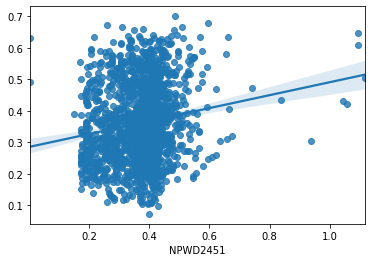

In [14]:
sns.regplot(y_test,predict)

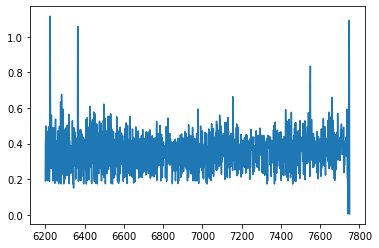

In [15]:
plt.plot(y_test)

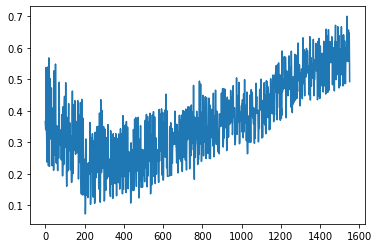

In [16]:
plt.plot(predict)

In [17]:
from metrics import rmse
print("RMSE = ", rmse(predict, y_test))

RMSE =  0.1473183462510855
